# Setup

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


# Define dataset

In [4]:
with open('files_remove_indices/small_data_remove_list_indexes.npy', 'rb') as f:
    remove_list = np.load(f)

In [5]:


from torch.utils.data import Dataset, DataLoader
import glob
import rasterio
class SwedishDataset(Dataset):
    def __init__(self,  transform  = None, remove_list = None):
        self.imgs_path = "SwedenData/100tiles/"
        file_list_dem1 = sorted(glob.glob(self.imgs_path + 'dem/'+ "*/*"))
        file_list_sat1 = sorted(glob.glob(self.imgs_path + 'sat/'+ "*/*"))

        self.data = []
        for img_path_dem,img_path_sat in zip(file_list_dem1,file_list_sat1):
          self.data.append([img_path_dem,img_path_sat])

        self.transform = transform
        #self.dems1_list = file_list_dem1 
        #self.sat1_list = file_list_sat1
        if remove_list is not None:
            self.data = np.array(self.data)
            mask = np.ones(len(self.data), dtype=bool)
            mask[remove_list] = False
            self.data = self.data[mask]

        
    def __len__(self):
        return len(self.data)


    def convert_to_classes(self, temp_tensor):
          mask_tensor_1 = (temp_tensor == 111)|(temp_tensor == 112)|(temp_tensor == 113)|(temp_tensor == 114)|(temp_tensor== 115)|(temp_tensor == 116)|(temp_tensor == 117) 
          mask_tensor_2 = (temp_tensor == 118)
          mask_tensor_3 = (temp_tensor == 121)|(temp_tensor == 122)|(temp_tensor == 123)|(temp_tensor== 124)|(temp_tensor == 125)|(temp_tensor == 126)|(temp_tensor == 127)
          mask_tensor_4 = (temp_tensor == 128)
          mask_tensor_5 = (temp_tensor == 2)
          mask_tensor_6 = (temp_tensor == 3)
          mask_tensor_7 = (temp_tensor == 41)|(temp_tensor== 42)
          mask_tensor_8 = (temp_tensor == 51)|(temp_tensor == 52)|(temp_tensor == 53)
          mask_tensor_9 = (temp_tensor == 61)|(temp_tensor == 62)
          mask_tensor_outside = (temp_tensor==0)
          mask_tensors = [mask_tensor_1,mask_tensor_2,mask_tensor_3,mask_tensor_4,
                          mask_tensor_5,mask_tensor_6, mask_tensor_7,mask_tensor_8,
                          mask_tensor_9, mask_tensor_outside]
          temp_image = temp_tensor
          for i in range(10):
            temp_image = torch.where(mask_tensors[i], torch.tensor(i), temp_image)
          return temp_image
    
          
    def __getitem__(self, idx):
        img_path_dem, img_path_sat = self.data[idx]
        img_raster_dem = rasterio.open(img_path_dem).read()#[:,:96,:96]
        img_raster_sat = rasterio.open(img_path_sat).read()#[:,:170,:350]
        img_raster_sat = self.convert_to_classes(torch.from_numpy(img_raster_sat))
        
        if img_raster_dem[0].shape!=(100,100):
            if img_raster_dem[0][0,0]==0:
                img_raster_dem = img_raster_dem[:,1:,:]
            else:
                img_raster_dem = img_raster_dem[:,:-1,:]
        
        if self.transform:
          img_raster_dem = self.transform(torch.tensor(img_raster_dem))
        
        test = img_raster_sat
        outside_class = 9
        if torch.equal(test[0][0,:], torch.ones(len(test[0][0,:]))*outside_class):
            test = test[:,1:,:]
        if torch.equal(test[0][-1,:], torch.ones(len(test[0][-1,:]))*outside_class):
            test = test[:,:-1,:]
        if torch.equal(test[0][:,0], torch.ones(len(test[0][:,0]))*outside_class):
            test = test[:,:,1:]
        if torch.equal(test[0][:,-1], torch.ones(len(test[0][:,-1]))*outside_class):
            test = test[:,:,:-1]
        img_raster_sat = test
        img_raster_sat = mask_resize(img_raster_sat)
        
        return [img_raster_dem ,img_raster_sat[0].type(torch.LongTensor)]
    
    
    
    
    
def normalize_input_for_dem(test_iter):
    #test_iter = torch.from_numpy(test_iter)
    input_images = test_iter.float()
    maxv = 822
    minv = -37
    #batch_size = input_images.shape[0]
    #cmin = torch.amin(input_images,(1,2)).reshape((batch_size,1,1))
    #cmax = torch.amax(input_images,(1,2)).reshape((batch_size,1,1))
    return (input_images-minv)/(maxv-minv) #(input_images-cmin)/(cmax-cmin)

class Normalize_range01:
    #bring to range 0 to 1

    def __init__(self, p=1):
        self.p = 1

    def __call__(self, x):
        result = normalize_input_for_dem(x)
        return result

    def __repr__(self):
        return "custom augmentation"

img_size = (96,96)
mask_resize = transforms.Resize(size = img_size, interpolation=Image.NEAREST)
#dem_resize = transforms.Resize(size = img_size)
data_transforms = transforms.Compose([#transforms.ToTensor(),
                                          transforms.Resize(size = img_size),
                                          Normalize_range01(),
                                          #transforms.ToPILImage(), 
                                          #transforms.RandomHorizontalFlip(),
                                          #transforms.RandomResizedCrop(size=100),
                                          #transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
                                          #transforms.RandomGrayscale(p=0.2),
                                          #transforms.GaussianBlur(kernel_size=9),
                                          #transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

from torch.utils.data import random_split
import math
dataset = SwedishDataset(transform = data_transforms, remove_list = remove_list)

with open('files_remove_indices/train_set_indexes.npy', 'rb') as f:
    train_set_indexes = np.load(f)

with open('files_remove_indices/test_set_indexes.npy', 'rb') as f:
    test_set_indexes = np.load(f)


train_dataset = torch.utils.data.Subset(dataset, train_set_indexes)
test_dataset = torch.utils.data.Subset(dataset, test_set_indexes)
print(len(train_dataset))
print(len(test_dataset))

print(dataset[4][0].shape)
dataset[4]


1943
344
torch.Size([1, 96, 96])


/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[tensor([[[-0.1199, -0.1199, -0.1222,  ..., -0.1572, -0.1572, -0.1595],
          [-0.1222, -0.1246, -0.1246,  ..., -0.1572, -0.1595, -0.1595],
          [-0.1222, -0.1246, -0.1246,  ..., -0.1572, -0.1595, -0.1595],
          ...,
          [-0.0477, -0.0454, -0.0431,  ..., -0.1618, -0.1641, -0.1618],
          [-0.0384, -0.0361, -0.0314,  ..., -0.1618, -0.1641, -0.1618],
          [-0.0314, -0.0291, -0.0244,  ..., -0.1618, -0.1618, -0.1641]]]),
 tensor([[0, 0, 0,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 8, 8, 8],
         [0, 6, 0,  ..., 8, 8, 8],
         ...,
         [0, 0, 0,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 8, 8, 8],
         [0, 0, 0,  ..., 8, 8, 8]])]

# Change of label

In [7]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

def apply_along_axis(function, x, axis,minlength: int = 0):
     return torch.stack([
                        function(x_i,minlength=minlength) for x_i in torch.unbind(x, dim=axis)
                        ], dim=axis)

In [8]:
apply_along_axis(torch.bincount,next(iter(train_dataloader))[1].flatten(start_dim=1), 0 ,minlength = 9)/9216

tensor([[4.4727e-01, 5.3494e-02, 1.9347e-01, 2.1701e-04, 2.5130e-01, 0.0000e+00,
         4.8611e-02, 5.0998e-03, 5.4253e-04],
        [3.0339e-01, 1.5375e-01, 1.3987e-01, 1.3021e-03, 3.8628e-01, 0.0000e+00,
         6.7274e-03, 5.0998e-03, 3.5807e-03],
        [5.5816e-01, 9.7656e-04, 2.2027e-02, 1.0851e-04, 3.4614e-01, 0.0000e+00,
         4.4379e-02, 0.0000e+00, 2.8212e-02],
        [3.5666e-01, 1.5473e-01, 5.9679e-02, 5.4253e-04, 3.9507e-01, 0.0000e+00,
         2.4089e-02, 9.2231e-03, 0.0000e+00],
        [6.5343e-01, 1.4106e-03, 5.4253e-03, 0.0000e+00, 1.6515e-01, 0.0000e+00,
         1.6764e-01, 0.0000e+00, 6.9444e-03],
        [2.8722e-01, 2.8429e-02, 2.3720e-01, 9.7656e-04, 4.3294e-01, 0.0000e+00,
         1.2153e-02, 1.0851e-03, 0.0000e+00],
        [6.2012e-01, 0.0000e+00, 1.1936e-02, 0.0000e+00, 3.1641e-01, 0.0000e+00,
         5.1324e-02, 0.0000e+00, 2.1701e-04],
        [1.0807e-01, 0.0000e+00, 5.8594e-03, 0.0000e+00, 3.1782e-01, 0.0000e+00,
         5.2517e-01, 0.0000e+0

# Model

# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
import torchvision
class Resnet18(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #resnet = torchvision.models.resnext50_32x4d(pretrained=True)
        resnet = torchvision.models.resnet18()
        
        num_input_channel = 1
        resnet.conv1 = nn.Conv2d(num_input_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
        #resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()
 
    def forward(self, x):
        return self.sigm(self.base_model(x))
 
# Initialize the model
model = Resnet18(n_classes = 9)
# Switch model to the training mode
model.train()
model.to(device)

criterion = nn.BCELoss()

In [9]:
# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
import torchvision
class Resnet18(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        #resnet = torchvision.models.resnext50_32x4d(pretrained=True)
        resnet = torchvision.models.resnet18()
        
        num_input_channel = 1
        resnet.conv1 = nn.Conv2d(num_input_channel, 64, kernel_size=7, stride=2, padding=3,bias=False)
        #resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        
 
    def forward(self, x):
        return self.base_model(x)
 
# Initialize the model
model = Resnet18(n_classes = 9)
# Switch model to the training mode
model.train()
model.to(device)

Resnet18(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
criterion = nn.CrossEntropyLoss()

max_epoch_number = 1000
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
log_every = 50
test_every = 50
save_checkpoint = "SwedenData/checkpoints/Segmentation_distribution_normranged_normalized_smalldata_1000epoch_celoss_global_bc64.pth"



In [ ]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Segmentation_distribution_smalldata_crossentr",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "resnet18",
    "dataset": "Sweden_small",
    "epochs": max_epoch_number,
    }
)

In [ ]:
#wandb.login(key="40706c6c21e200af3bdb3840883f22e665e74441")

In [10]:

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score,explained_variance_score

epoch = 0
iteration = 0
softmax = nn.Softmax(dim=1)
model.train()
while True:
    batch_losses = []
    Y_list = []
    Y_pred_N_list = []

    for imgs, targets in train_dataloader:
        targets = apply_along_axis(torch.bincount,targets.flatten(start_dim=1), 0 ,minlength = 9)/9216
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
 
        model_result = model(imgs)
        loss = criterion(model_result, targets.type(torch.float))
 
        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()
 
        batch_losses.append(batch_loss_value)
        wandb.log({'iteration_loss': loss.item()})
 
        iteration += 1

        if epoch % log_every==0:
            Y_list.append(targets)
            Y_pred_N_list.append(softmax(model_result))

    
    my_lr_scheduler.step()
    current_lr = my_lr_scheduler.get_last_lr()[0]
    loss_value = np.mean(batch_losses)
    wandb.log({"epoch_loss": loss_value, "learning_rate": current_lr})



    if epoch % log_every==0:
        model_name = save_checkpoint
        torch.save(model.state_dict(), model_name)

        kl_div = F.kl_div(torch.vstack(Y_pred_N_list).log(), torch.vstack(Y_list), None, None, 'batchmean')
        wandb.log({"train_KL_divergence": kl_div})

        msle = []#(the best value is 0.0)
        mse = []#(the best value is 0.0)
        r2 = []#Best possible score is 1.0 and it can be negative
        evs = []#Best possible score is 1.0, lower values are worse.
        with torch.no_grad():
            for y_true,y_pred in zip(torch.vstack(Y_list).cpu().numpy(), torch.vstack(Y_pred_N_list).cpu().numpy()):
                msle.append(mean_squared_log_error(y_true, y_pred))
                mse.append(mean_squared_error(y_true, y_pred))
                r2.append(r2_score(y_true, y_pred))
                evs.append(explained_variance_score(y_true, y_pred))
            wandb.log({"train_mean_squared_log_error": np.mean(msle),
                      "train_mean_squared_error": np.mean(mse),
                      "train_r2_score": np.mean(r2),
                      "train_explained_variance_score": np.mean(evs)})



    if epoch % test_every==0:
        model.eval()

        Y_list = []
        Y_pred_N_list = []
        with torch.no_grad():
            for X,Y in train_dataloader:
                X, Y = X.to(device), Y.to(device)
                Y_pred_N = model(X)
                targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
                Y_list.append(targets)
                Y_pred_N_list.append(softmax(Y_pred_N))

        kl_div = F.kl_div(torch.vstack(Y_pred_N_list).log(), torch.vstack(Y_list), None, None, 'batchmean')
        wandb.log({"traineval_KL_divergence": kl_div})

        msle = []#(the best value is 0.0)
        mse = []#(the best value is 0.0)
        r2 = []#Best possible score is 1.0 and it can be negative
        evs = []#Best possible score is 1.0, lower values are worse.
        with torch.no_grad():
            for y_true,y_pred in zip(torch.vstack(Y_list).cpu().numpy(), torch.vstack(Y_pred_N_list).cpu().numpy()):
                msle.append(mean_squared_log_error(y_true, y_pred))
                mse.append(mean_squared_error(y_true, y_pred))
                r2.append(r2_score(y_true, y_pred))
                evs.append(explained_variance_score(y_true, y_pred))
            wandb.log({"traineval_mean_squared_log_error": np.mean(msle),
                      "traineval_mean_squared_error": np.mean(mse),
                      "traineval_r2_score": np.mean(r2),
                      "traineval_explained_variance_score": np.mean(evs)})


        Y_list = []
        Y_pred_N_list = []
        with torch.no_grad():
            for X,Y in test_dataloader:
                X, Y = X.to(device), Y.to(device)
                Y_pred_N = model(X)
                targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
                Y_list.append(targets)
                Y_pred_N_list.append(softmax(Y_pred_N))

        kl_div = F.kl_div(torch.vstack(Y_pred_N_list).log(), torch.vstack(Y_list), None, None, 'batchmean')
        wandb.log({"testeval_KL_divergence": kl_div})

        msle = []#(the best value is 0.0)
        mse = []#(the best value is 0.0)
        r2 = []#Best possible score is 1.0 and it can be negative
        evs = []#Best possible score is 1.0, lower values are worse.
        with torch.no_grad():
            for y_true,y_pred in zip(torch.vstack(Y_list).cpu().numpy(), torch.vstack(Y_pred_N_list).cpu().numpy()):
                msle.append(mean_squared_log_error(y_true, y_pred))
                mse.append(mean_squared_error(y_true, y_pred))
                r2.append(r2_score(y_true, y_pred))
                evs.append(explained_variance_score(y_true, y_pred))
            wandb.log({"testeval_mean_squared_log_error": np.mean(msle),
                      "testeval_mean_squared_error": np.mean(mse),
                      "testeval_r2_score": np.mean(r2),
                      "testeval_explained_variance_score": np.mean(evs)})


        model.train()



epoch: 0 iter: 65 train: loss:1.541
epoch: 1 iter:130 train: loss:1.483


# Evaluation

In [10]:
model_path = "SwedenData/checkpoints/Segmentation_distribution_normranged_normalized_smalldata_1000epoch_celoss.pth"
model = Resnet18(n_classes = 9).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

Resnet18(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
import torch.nn.functional as F

## Train dataset evaluation

In [18]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score,explained_variance_score

In [19]:
softmax = nn.Softmax(dim=1)
input = torch.randn(2, 3)
print(input)
softmax(input)

tensor([[ 0.2403, -0.0272,  0.7854],
        [ 1.8115, -0.1999,  2.0063]])


tensor([[0.2865, 0.2193, 0.4942],
        [0.4257, 0.0570, 0.5173]])

In [21]:
Y_list = []
Y_pred_N_list = []
softmax = nn.Softmax(dim=1)
with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y.to(device)
        Y_pred_N = model(X)
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        Y_list.append(targets)
        Y_pred_N_list.append(softmax(Y_pred_N))

kl_div = F.kl_div(torch.vstack(Y_pred_N_list).log(), torch.vstack(Y_list), None, None, 'batchmean')


msle = []#(the best value is 0.0)
mse = []#(the best value is 0.0)
r2 = []#Best possible score is 1.0 and it can be negative
evs = []#Best possible score is 1.0, lower values are worse.
with torch.no_grad():
    for y_true,y_pred in zip(torch.vstack(Y_list).cpu().numpy(), torch.vstack(Y_pred_N_list).cpu().numpy()):
        msle.append(mean_squared_log_error(y_true, y_pred))
        mse.append(mean_squared_error(y_true, y_pred))
        r2.append(r2_score(y_true, y_pred))
        evs.append(explained_variance_score(y_true, y_pred))
    
print(np.mean(msle))
print(np.mean(mse))
print(np.mean(r2))
print(np.mean(evs))

/home/azamat.kaibaldiyev/miniconda3/envs/contrastive_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.004522842
0.0076029
0.7220226487827641
0.7220226491606513


In [ ]:
#

tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111]])
KL divergence is:  tensor(0.9848)


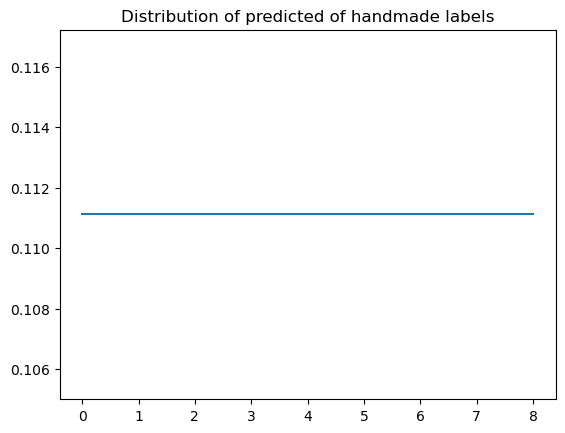

In [39]:
# Evaluating with uniform distribution

uniform_distr = (torch.ones(1,9)/9)
plt.plot(uniform_distr[0])
plt.title('Distribution of predicted of handmade labels')
print(uniform_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in train_dataset:
        X, Y = X.to(device), Y
        targets = torch.bincount(Y.flatten(), minlength = 9)/9216
        uniform_distr = (torch.ones(1,9)/9)
        
        kl_div = F.kl_div(uniform_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(train_dataset))

tensor([[0.1257, 0.0766, 0.1495, 0.0186, 0.0080, 0.0940, 0.1805, 0.2176, 0.1294]])
KL divergence is:  tensor(1.2621)


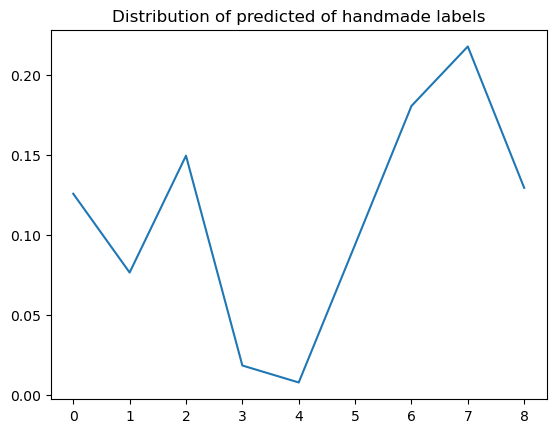

In [40]:
# Evaluating with random distribution

rand_tens = torch.rand(1,9)
rand_distr = rand_tens/torch.sum(rand_tens)
plt.plot(rand_distr[0])
plt.title('Distribution of predicted of handmade labels')
print(rand_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in train_dataset:
        X, Y = X.to(device), Y
        targets = torch.bincount(Y.flatten(), minlength = 9)/9216
        rand_tens = torch.rand(1,9)
        rand_distr = rand_tens/torch.sum(rand_tens)
        
        kl_div = F.kl_div(rand_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(train_dataset))

tensor([0.1889, 0.1713, 0.1601, 0.1168, 0.1185, 0.0822, 0.0742, 0.0566, 0.0315])
KL divergence is:  tensor(0.8218)


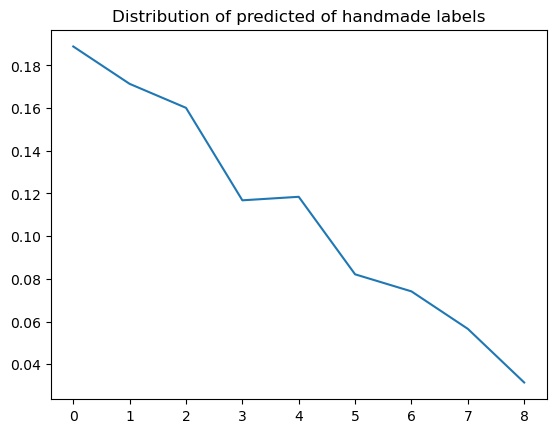

In [35]:
#Evaluating with slope distribution

slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
slope_distr = slope_distr/torch.sum(slope_distr)
plt.plot(slope_distr)
plt.title('Distribution of predicted of handmade labels')
print(slope_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in train_dataset:
        X, Y = X.to(device), Y
        targets = torch.bincount(Y.flatten(), minlength = 9)/9216
        slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
        slope_distr = slope_distr/torch.sum(slope_distr)
        
        kl_div = F.kl_div(slope_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(train_dataset))

tensor([0.1635, 0.1459, 0.1550, 0.1494, 0.1267, 0.0974, 0.0757, 0.0502, 0.0362])
KL divergence is:  tensor(0.8190)


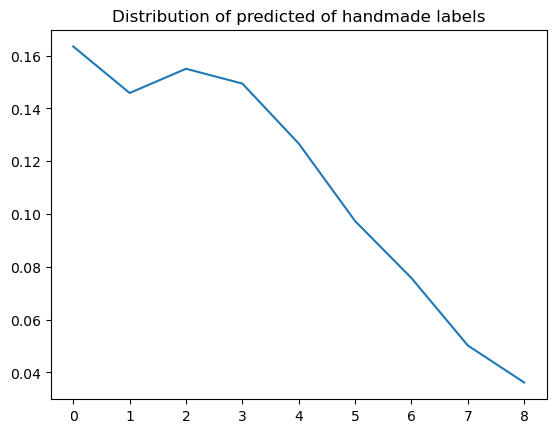

In [34]:
#Evaluating with slope distribution

slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
slope_distr = slope_distr/torch.sum(slope_distr)
plt.plot(slope_distr)
plt.title('Distribution of predicted of handmade labels')
print(slope_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in train_dataset:
        X, Y = X.to(device), Y
        targets = torch.bincount(Y.flatten(), minlength = 9)/9216
        slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
        slope_distr = slope_distr/torch.sum(slope_distr)
        
        kl_div = F.kl_div(slope_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(train_dataset))

## Test dataset evaluation

In [256]:
model.eval()
print(len(test_dataloader))
kl_div_list = []

with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y.to(device)
        Y_pred_N = model(X)
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        
        kl_div = F.kl_div(Y_pred_N.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)

print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(test_dataset))

8
KL divergence is:  tensor(0.1779, device='cuda:0')


tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111]])
KL divergence is:  tensor(0.8755)


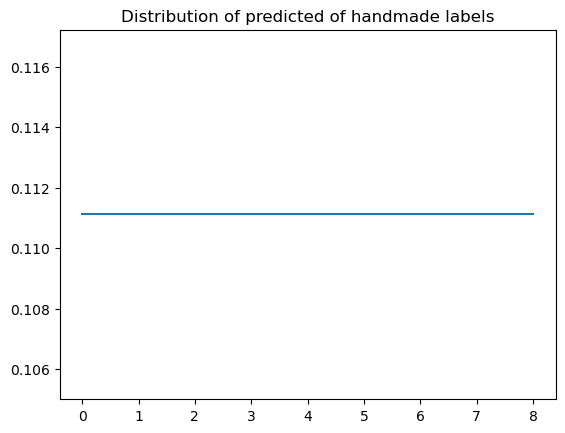

In [274]:
# Evaluating with uniform distribution

uniform_distr = (torch.ones(1,9)/9)
plt.plot(uniform_distr[0])
plt.title('Distribution of predicted of handmade labels')
print(uniform_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        uniform_distr = (torch.ones(len(Y),9)/9)
        
        kl_div = F.kl_div(uniform_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(test_dataset))

tensor([[0.0008, 0.0687, 0.1685, 0.2094, 0.0098, 0.1934, 0.1115, 0.1706, 0.0672]])
KL divergence is:  tensor(1.2375)


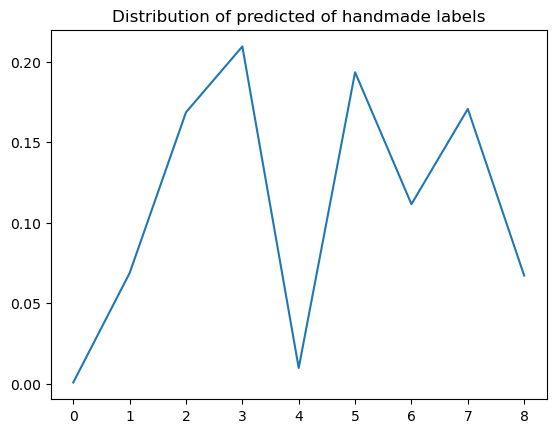

In [273]:
# Evaluating with random distribution

rand_tens = torch.rand(1,9)
rand_distr = rand_tens/torch.sum(rand_tens)
plt.plot(rand_distr[0])
plt.title('Distribution of predicted of handmade labels')
print(rand_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        rand_tens = torch.rand(1,9)
        rand_distr = rand_tens/torch.sum(rand_tens)
        
        kl_div = F.kl_div(rand_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(test_dataset))

tensor([0.1761, 0.1713, 0.1678, 0.1435, 0.1015, 0.0855, 0.0690, 0.0472, 0.0381])
KL divergence is:  tensor(0.6701)


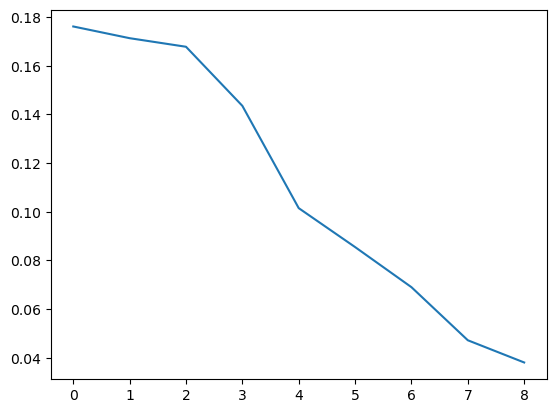

In [266]:
#Evaluating with slope distribution

slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
slope_distr = slope_distr/torch.sum(slope_distr)
plt.plot(slope_distr)
plt.title('Distribution of predicted of handmade labels')
print(slope_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        slope_distr = torch.normal(mean=torch.arange(10., 1., -1.), std=torch.arange(1, 0.1, -0.1))
        slope_distr = slope_distr/torch.sum(slope_distr)
        
        kl_div = F.kl_div(slope_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(test_dataset))

tensor([    0.8333,     0.1389,     0.0231,     0.0039,     0.0006,     0.0001,
            0.0000,     0.0000,     0.0000])
KL divergence is:  tensor(2.5397)


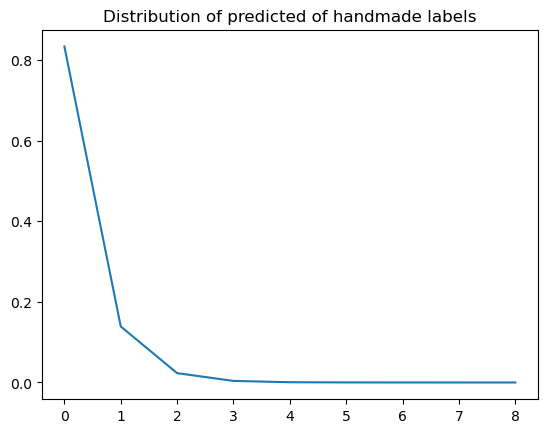

In [268]:
#Evaluating with slope distribution

exp = torch.arange(10., 1.,-1)
base = 6
torch.pow(base, exp)
slope_distr = torch.pow(base, exp)
slope_distr = slope_distr/torch.sum(slope_distr)
plt.plot(slope_distr)
plt.title('Distribution of predicted of handmade labels')
print(slope_distr)

kl_div_list = []
with torch.no_grad():
    for X,Y in test_dataloader:
        X, Y = X.to(device), Y
        targets = apply_along_axis(torch.bincount,Y.flatten(start_dim=1), 0 ,minlength = 9)/9216
        exp = torch.arange(10., 1.,-1)
        base = 6
        torch.pow(base, exp)
        slope_distr = torch.pow(base, exp)
        slope_distr = slope_distr/torch.sum(slope_distr)
        
        kl_div = F.kl_div(slope_distr.log(), targets, None, None, 'none')
        kl_div_list.append(kl_div)
print('KL divergence is: ', torch.sum(torch.vstack(kl_div_list))/len(test_dataset))

In [102]:
torch.set_printoptions(precision=4,sci_mode=False)

In [257]:
targets[:4]

tensor([[0.6457, 0.1137, 0.0119, 0.0000, 0.1339, 0.0000, 0.0809, 0.0041, 0.0097],
        [0.3980, 0.1927, 0.0209, 0.0000, 0.1913, 0.0000, 0.1809, 0.0116, 0.0046],
        [0.4849, 0.0565, 0.0571, 0.0000, 0.3279, 0.0000, 0.0356, 0.0051, 0.0329],
        [0.4513, 0.0570, 0.0450, 0.0000, 0.3576, 0.0000, 0.0891, 0.0000, 0.0000]],
       device='cuda:0')

In [264]:
np.set_printoptions(precision=4,suppress=True)
Y_pred_N[:4].cpu().numpy()

array([[0.5361, 0.0764, 0.066 , 0.0003, 0.2285, 0.0002, 0.0481, 0.0052,
        0.0228],
       [0.5693, 0.0417, 0.0617, 0.0004, 0.2194, 0.0005, 0.072 , 0.0084,
        0.0136],
       [0.323 , 0.1408, 0.0597, 0.0003, 0.4116, 0.0001, 0.021 , 0.0066,
        0.0287],
       [0.4946, 0.1352, 0.0513, 0.0003, 0.2781, 0.0001, 0.025 , 0.004 ,
        0.0178]], dtype=float32)

# Pytorch lightning model

In [ ]:
import torchvision.models as models


class ImagenetTransferLearning(LightningModule):
    def __init__(self):
        super().__init__()

        # init a pretrained resnet
        backbone = models.resnet50(weights="DEFAULT")
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        # use the pretrained model to classify cifar-10 (10 image classes)
        num_target_classes = 10
        self.classifier = nn.Linear(num_filters, num_target_classes)

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        ...

In [ ]:
model = ImagenetTransferLearning()
trainer = Trainer()
trainer.fit(model)

In [ ]:
model = ImagenetTransferLearning.load_from_checkpoint(PATH)
model.freeze()

x = some_images_from_cifar10()
predictions = model(x)

# Define model

In [18]:
data_loader = DataLoader(train_dataset, batch_size=4)
print(len(train_dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

2058 515
torch.Size([4, 1, 96, 96]) torch.Size([4, 96, 96])


In [19]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 9, 96, 96])


# Train

In [22]:
batch_size = 32

epochs = 1000
lr = 0.001

In [23]:
#dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(train_dataset, batch_size=batch_size)

In [24]:
model = UNet(num_classes=num_classes).to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [26]:
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [ ]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    my_lr_scheduler.step()
    epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

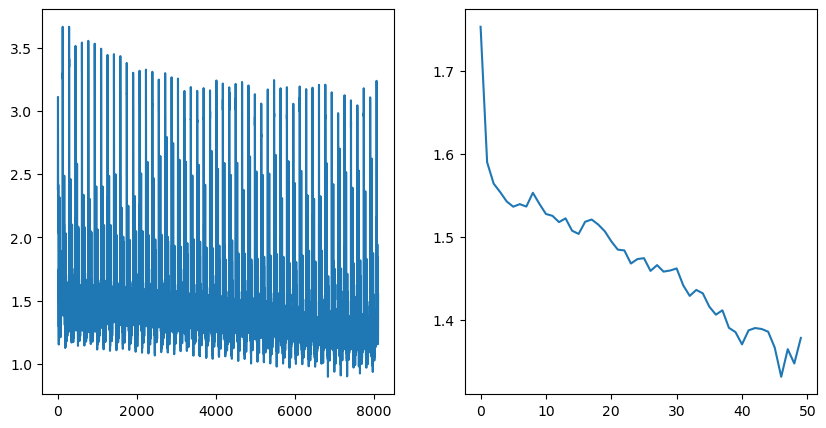

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

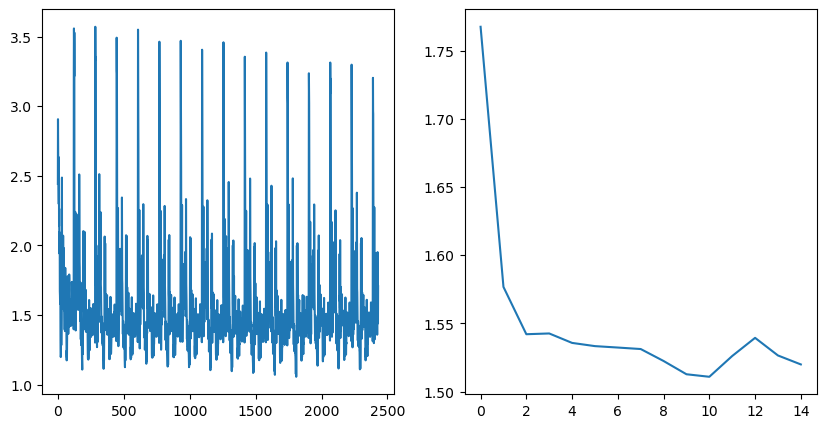

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

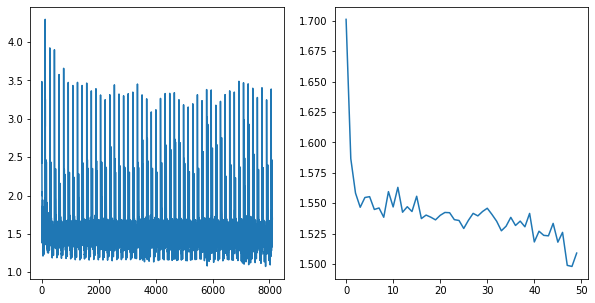

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

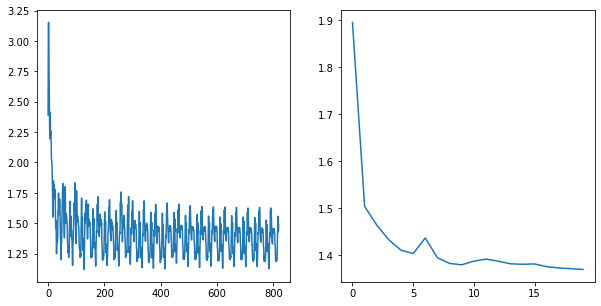

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

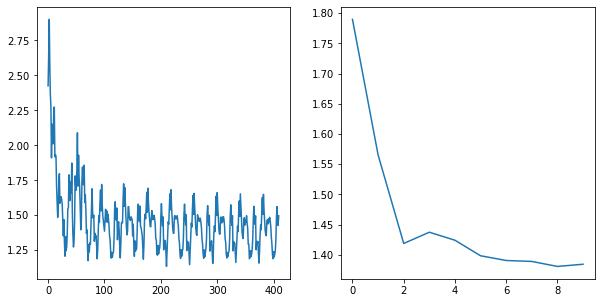

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

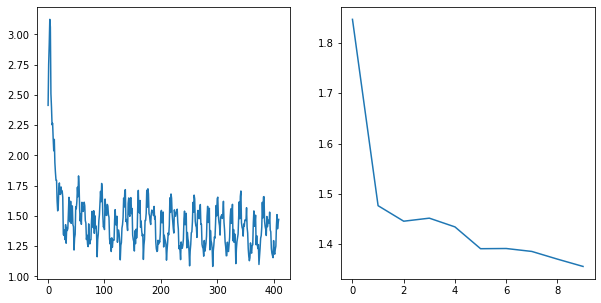

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [ ]:
model_name = "SwedenData/checkpoints/U-Net_normranged_normalized_all_data_1000epoch.pth"
torch.save(model.state_dict(), model_name)

# Check model preds

In [34]:
model_path = "SwedenData/checkpoints/U-Net_normranged_normalized_all_data_1000epoch.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [35]:
train_batch_size = 8
#dataset = CityscapeDataset(val_dir, label_model)
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size)

In [36]:
model_.eval()
X, Y = next(iter(train_data_loader ))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 9, 96, 96])
torch.Size([8, 96, 96])


In [39]:
label_class_predicted

array([[4, 4, 4, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0],
       [4, 4, 8, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [40]:
label_class 

array([[8, 8, 8, ..., 0, 0, 0],
       [8, 8, 8, ..., 0, 0, 0],
       [8, 8, 8, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 6],
       [0, 0, 0, ..., 6, 0, 4],
       [0, 0, 0, ..., 2, 0, 4]])

In [29]:
Y.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')

In [30]:
Y_pred.unique()

tensor([0, 1, 4, 6, 7, 8], device='cuda:0')

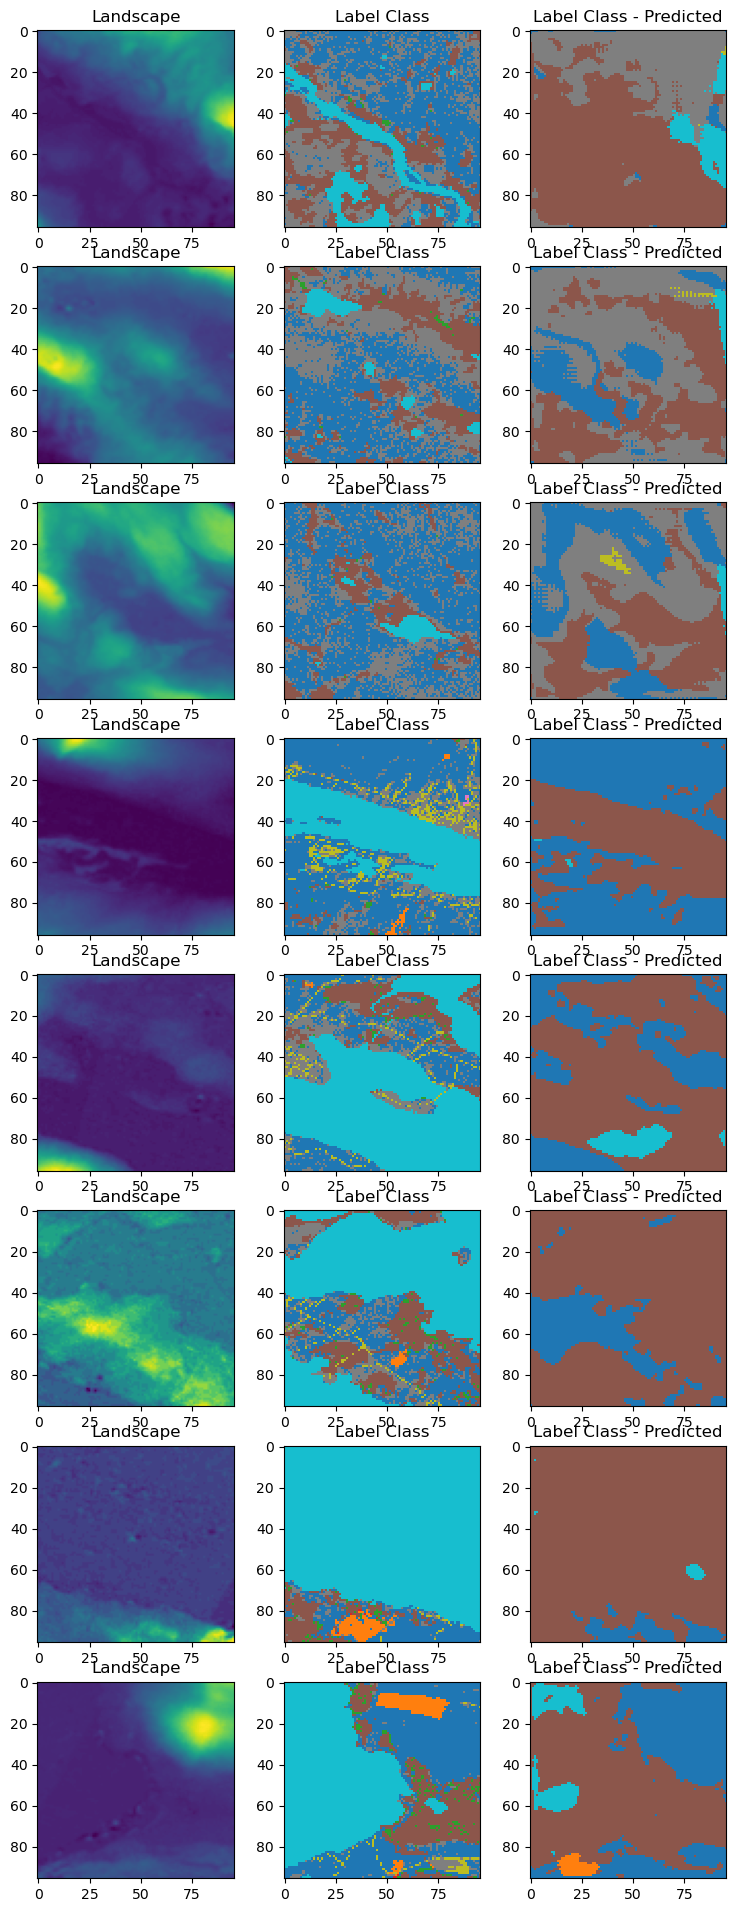

In [43]:
fig, axes = plt.subplots(train_batch_size, 3, figsize=(3*3, train_batch_size*3))

for i in range(train_batch_size):
    
    #landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap='tab10', vmin=0, vmax=num_classes-1, interpolation='nearest')
    axes[i, 1].set_title("Label Class")
    ax3 = axes[i, 2].imshow(label_class_predicted, cmap='tab10', vmin=0, vmax=num_classes-1, interpolation='nearest')
    axes[i, 2].set_title("Label Class - Predicted")
    #cbar = plt.colorbar(ax3)
    #ax3.set_clim(-0.5, 10 - 0.5)
    #ticks = np.arange(10)
    #cbar.set_ticks(ticks ,labels = tick_labels)
    ###cmap='tab10' 'Set1'

In [44]:
test_batch_size = 8
#dataset = CityscapeDataset(val_dir, label_model)
test_data_loader = DataLoader(test_dataset, batch_size=test_batch_size)

In [45]:
model_.eval()
X, Y = next(iter(test_data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 9, 96, 96])
torch.Size([8, 96, 96])


In [37]:
#inverse_transform = transforms.Compose([
#    transforms.Normalize((-0.5/0.5), (1/0.5))
#])

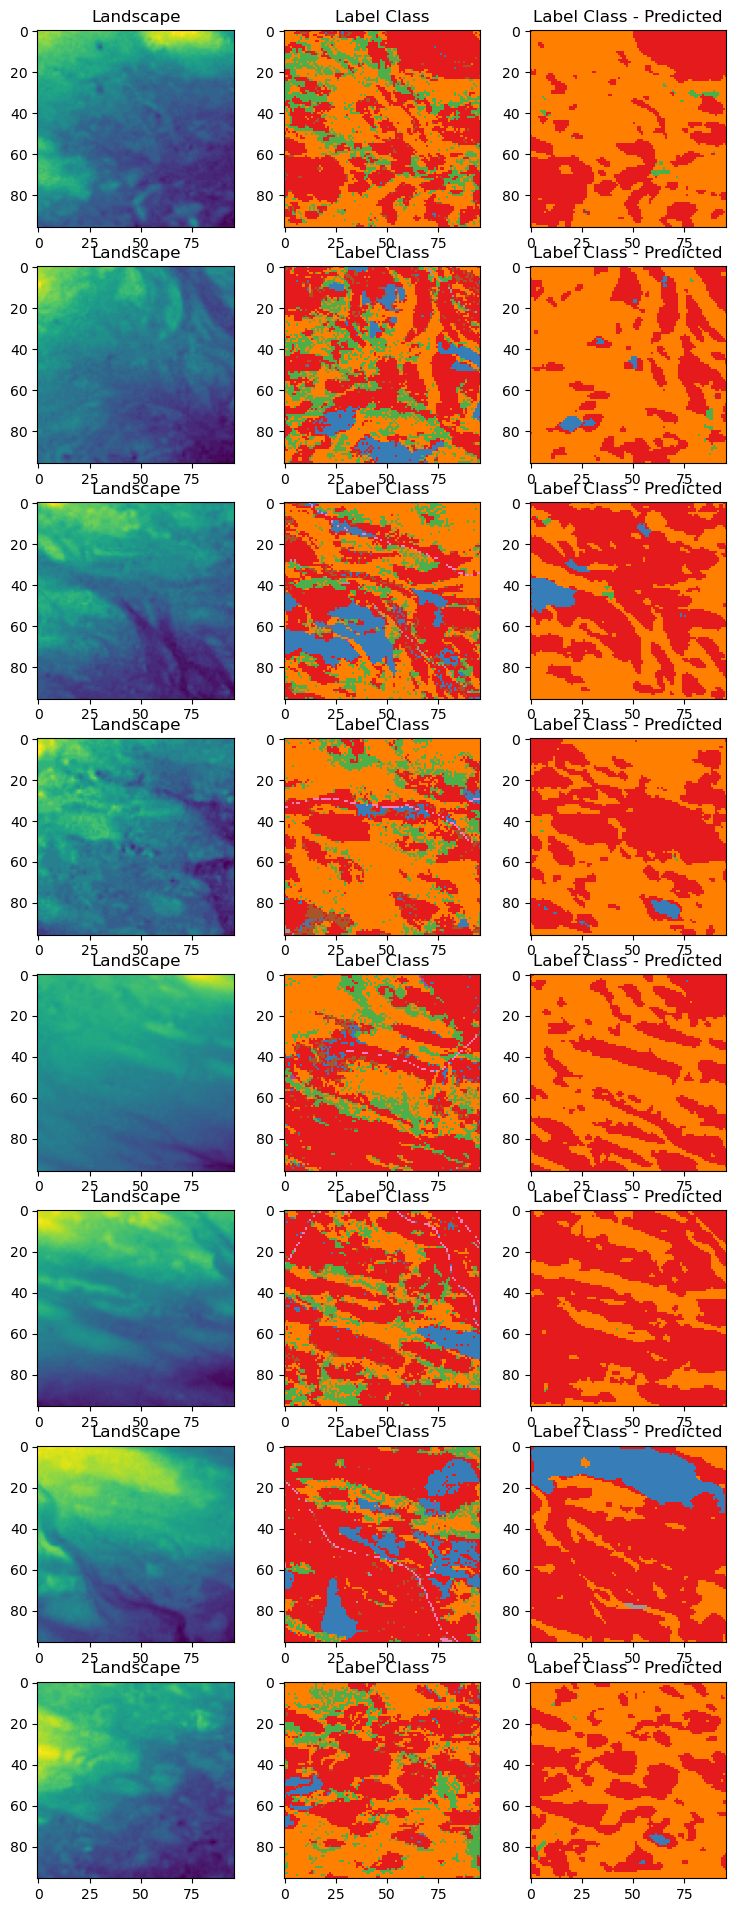

In [46]:
# full dataset corrected
#500 epochs
#global range normalization between 0 and 1
# mean and variance normalization
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*3, test_batch_size*3))

for i in range(test_batch_size):
    
    #landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap='Set1', vmin=0, vmax=num_classes-1, interpolation='nearest')
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, cmap='Set1', vmin=0, vmax=num_classes-1, interpolation='nearest')
    axes[i, 2].set_title("Label Class - Predicted")

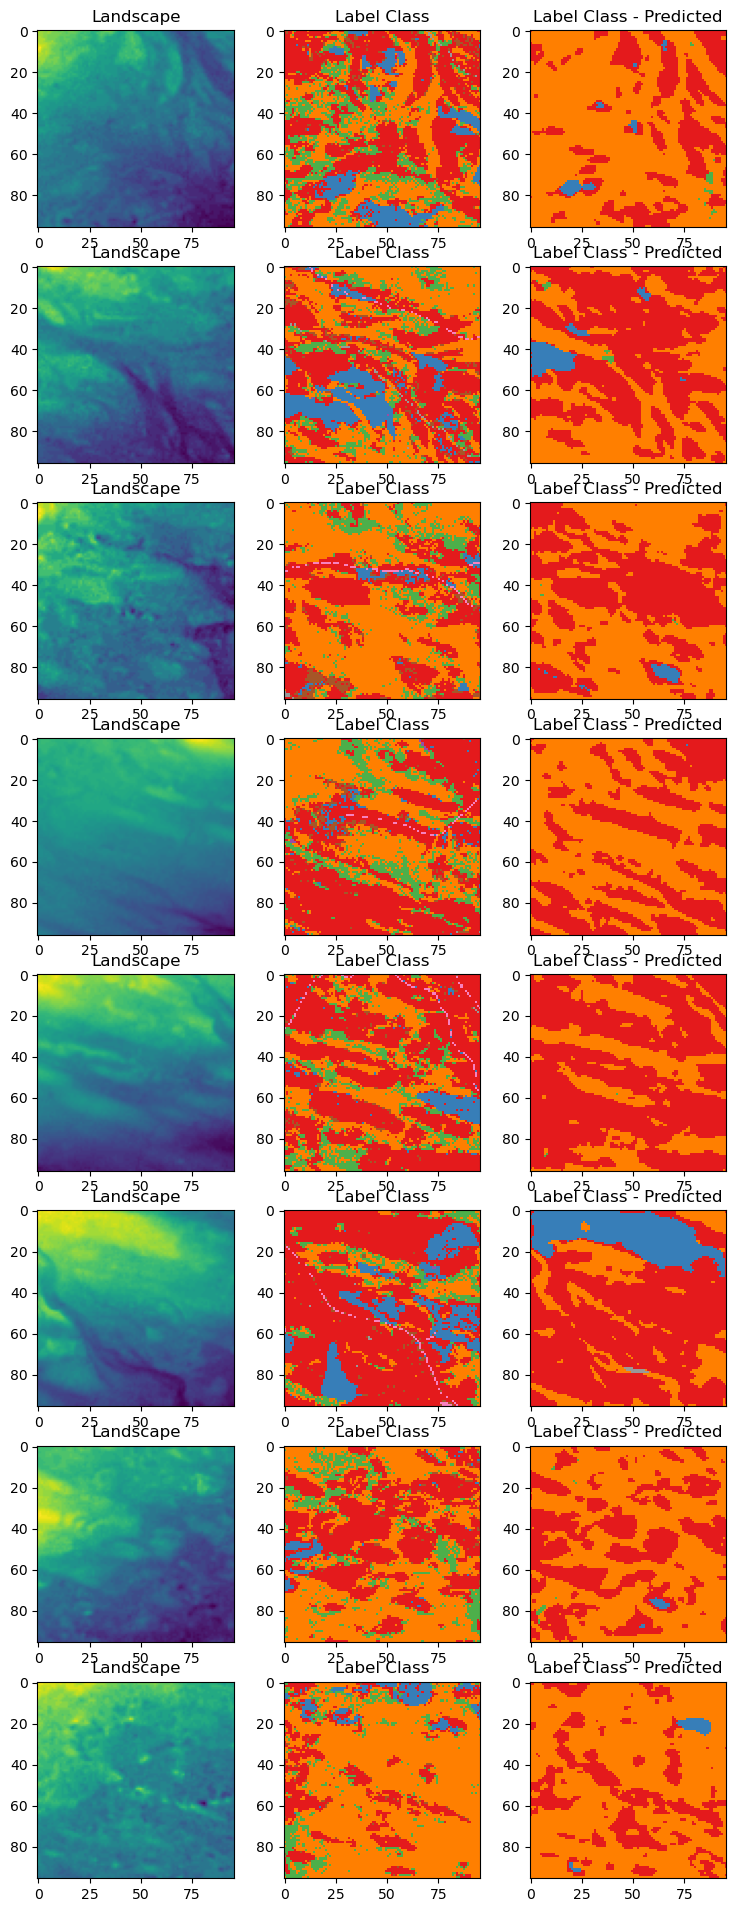

In [40]:
# full dataset corrected
#500 epochs
#global range normalization between 0 and 1
# mean and variance normalization
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*3, test_batch_size*3))

for i in range(test_batch_size):
    
    #landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap='Set1', vmin=0, vmax=num_classes-1, interpolation='nearest')
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, cmap='Set1', vmin=0, vmax=num_classes-1, interpolation='nearest')
    axes[i, 2].set_title("Label Class - Predicted")

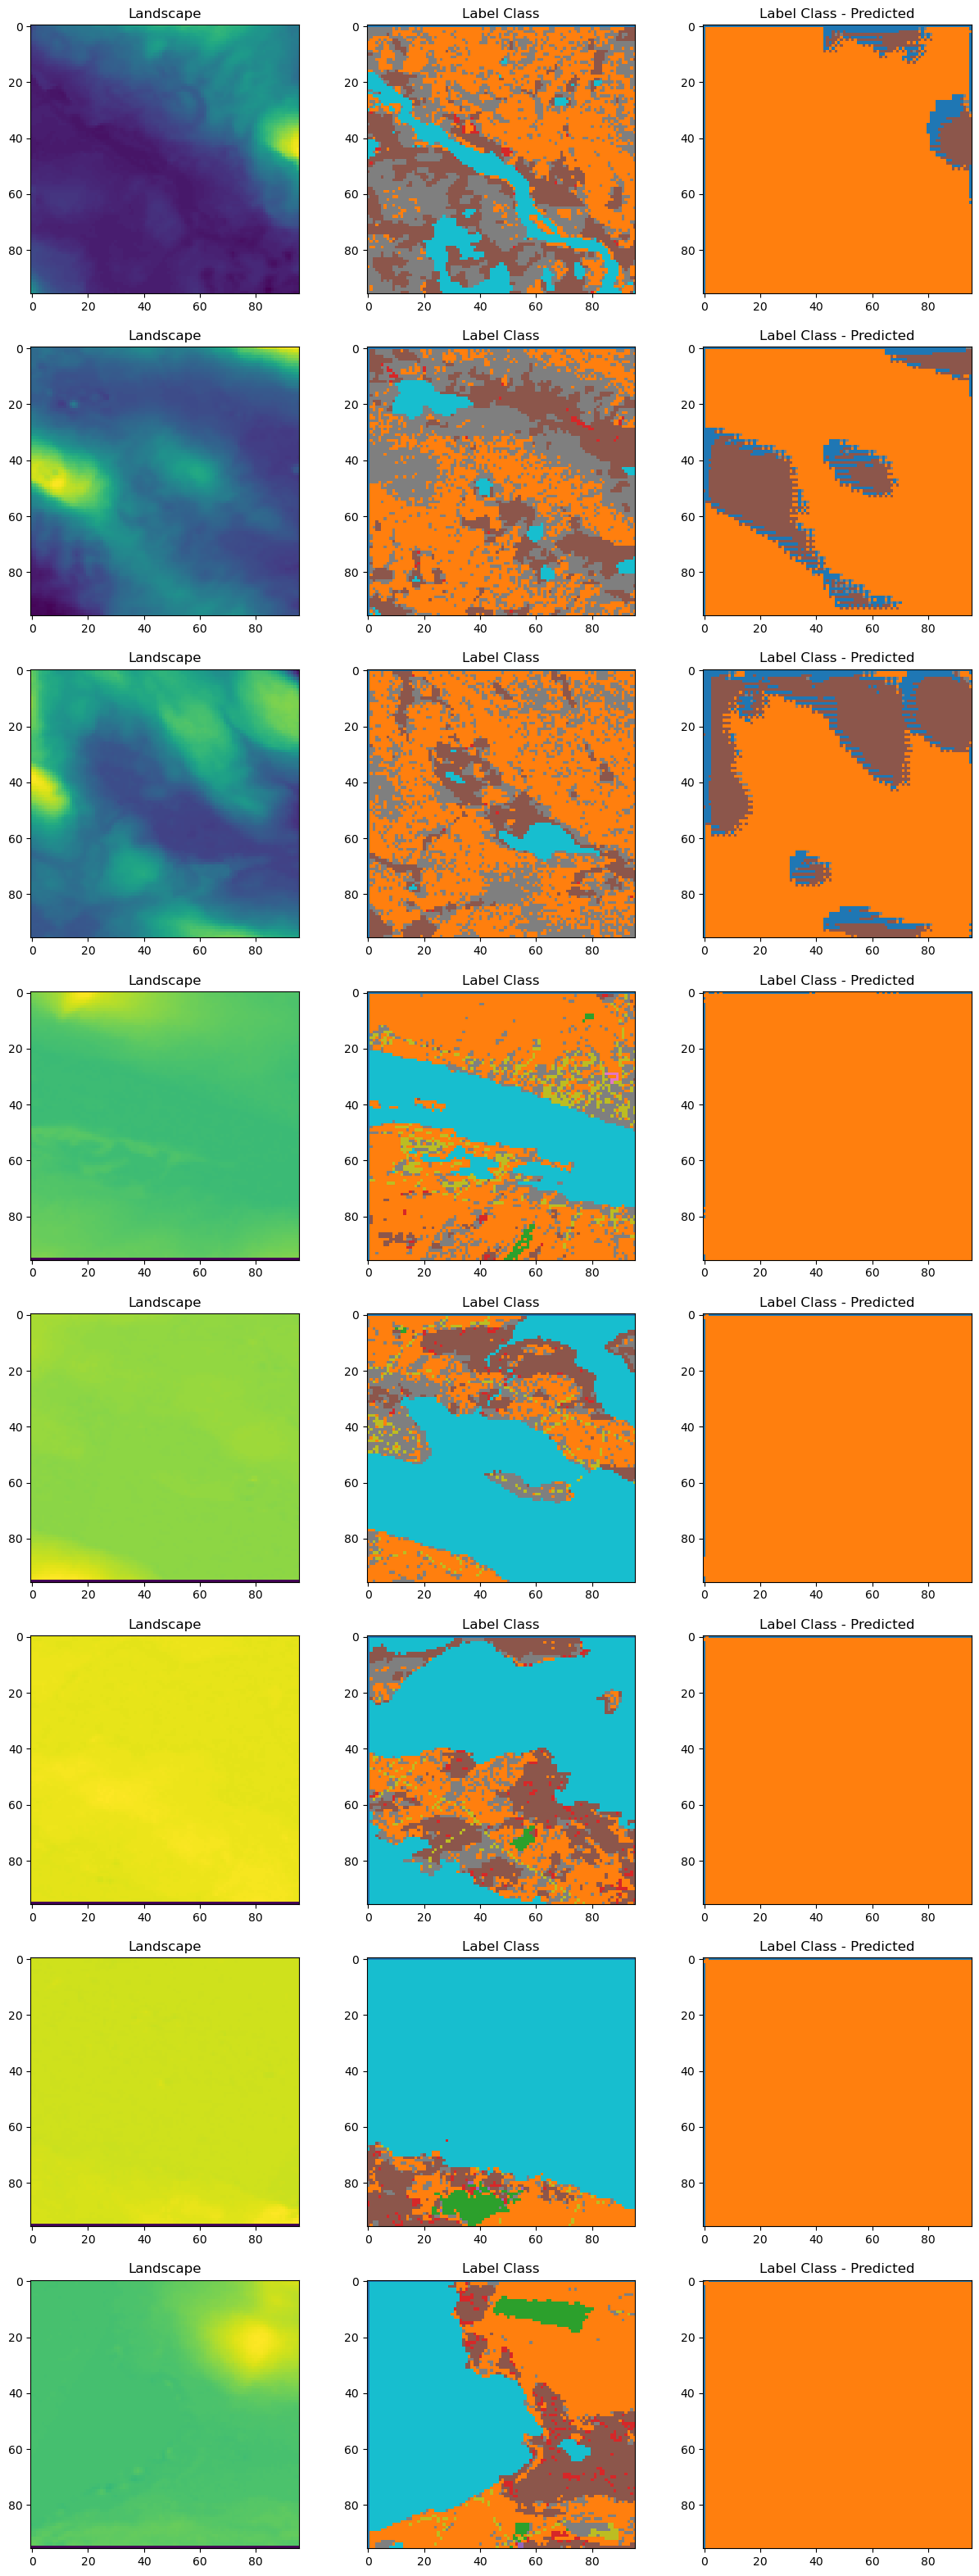

In [120]:
# full dataset corrected
#15 epochs
#global range normalization between 0 and 1
# mean and variance normalization
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    #landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap='tab10', vmin=0, vmax=num_classes-1)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, cmap='tab10', vmin=0, vmax=num_classes-1)
    axes[i, 2].set_title("Label Class - Predicted")

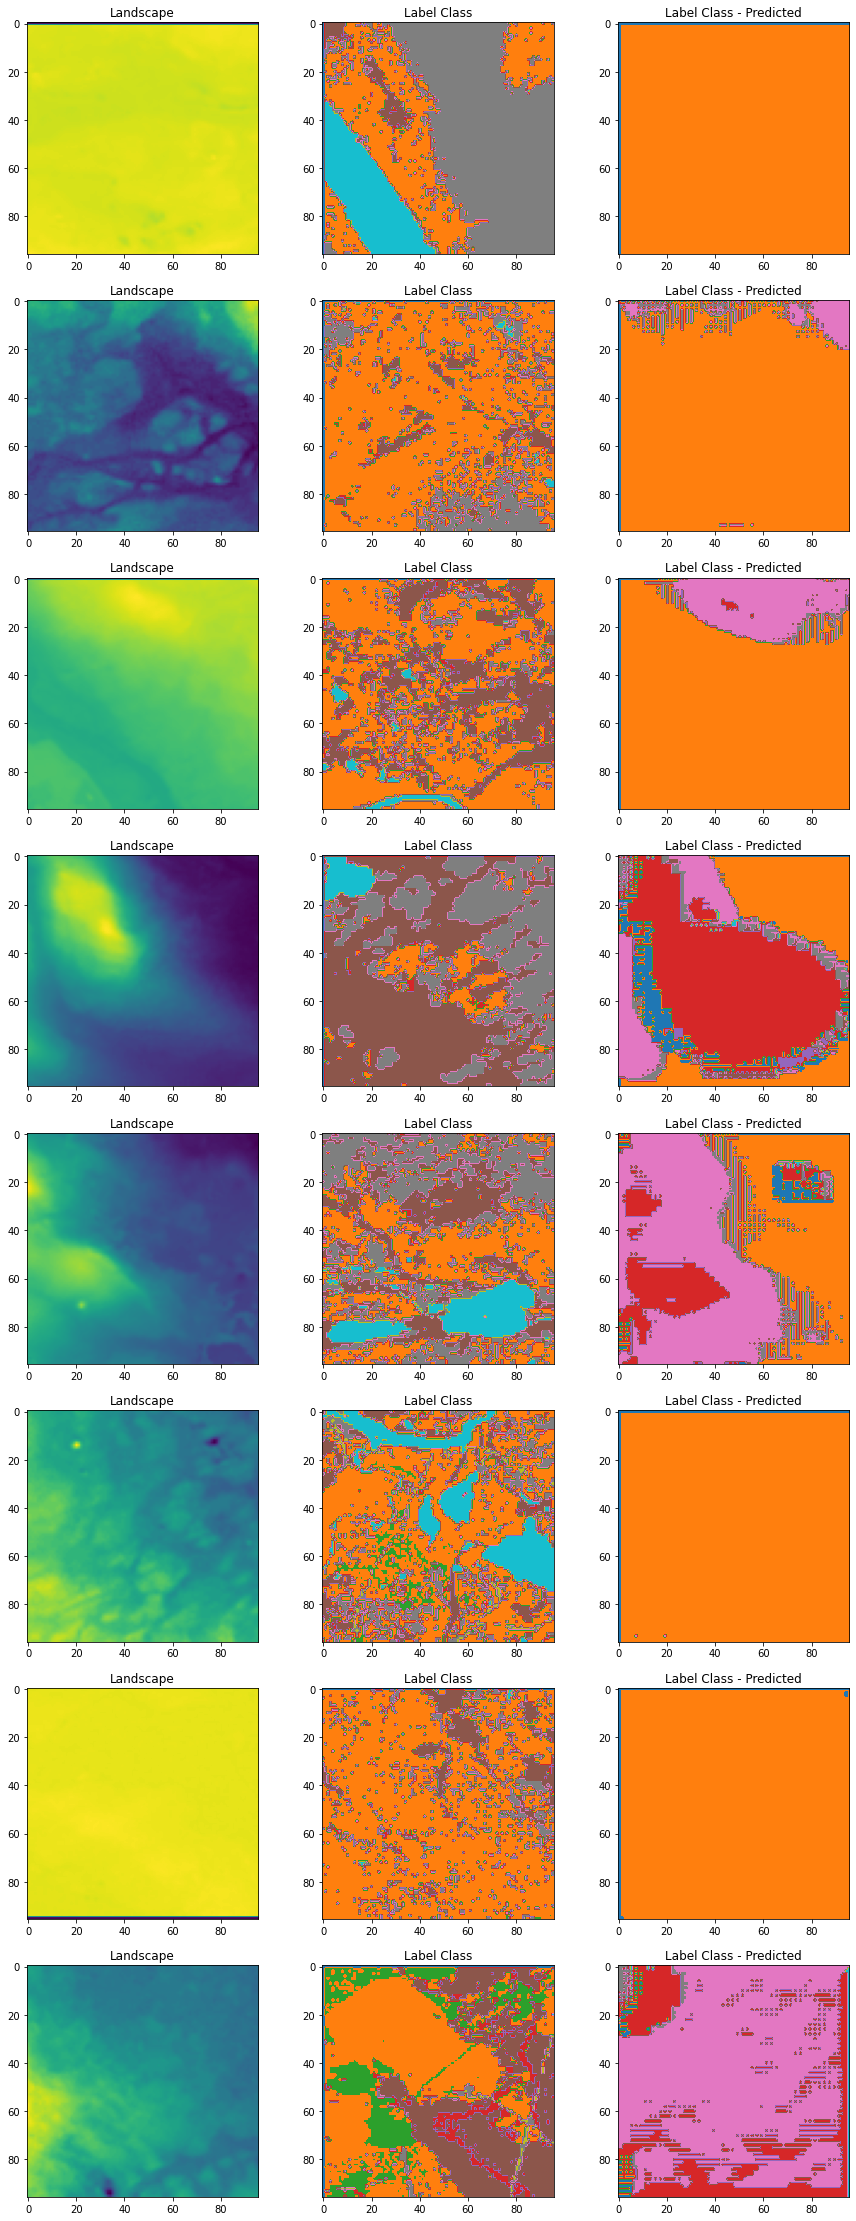

In [16]:
# full dataset
#50 epochs
#global range normalization between 0 and 1
# mean and variance normalization
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    #landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap='tab10', vmin=0, vmax=num_classes-1)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, cmap='tab10', vmin=0, vmax=num_classes-1)
    axes[i, 2].set_title("Label Class - Predicted")

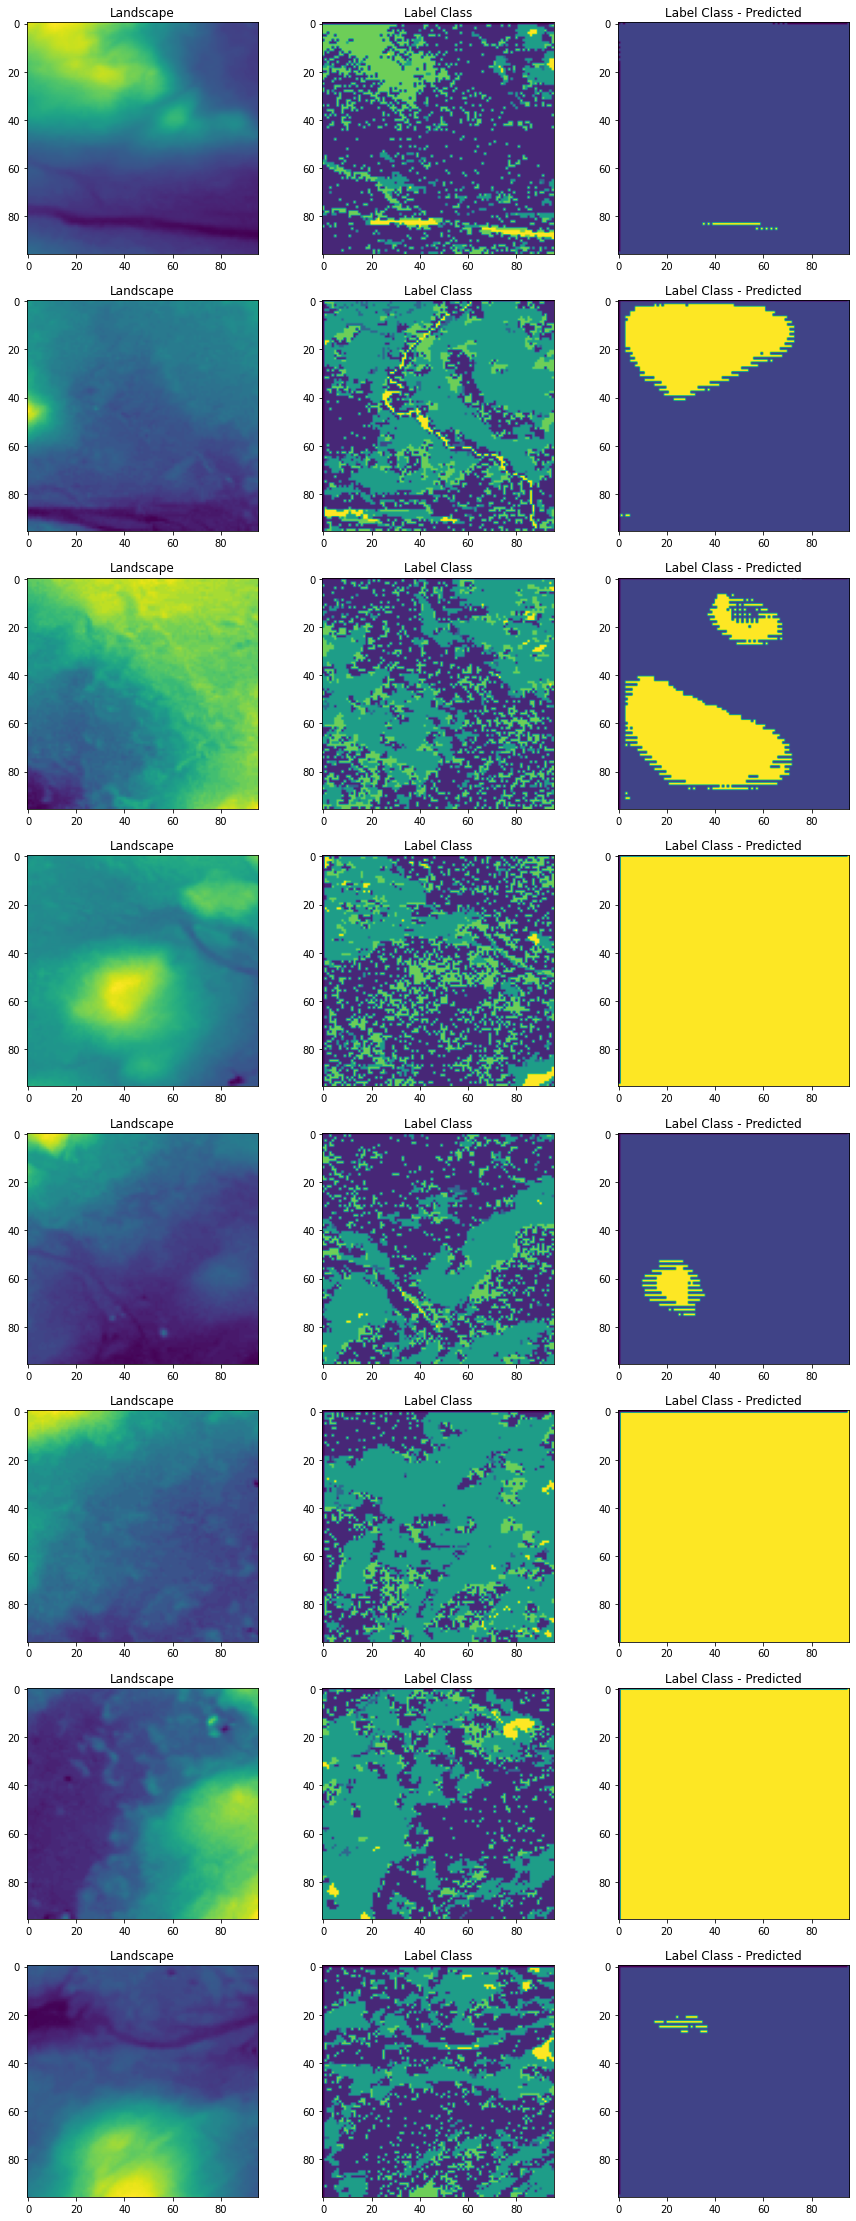

In [172]:
#global range normalization between 0 and 1
# mean and variance normalization
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    #landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

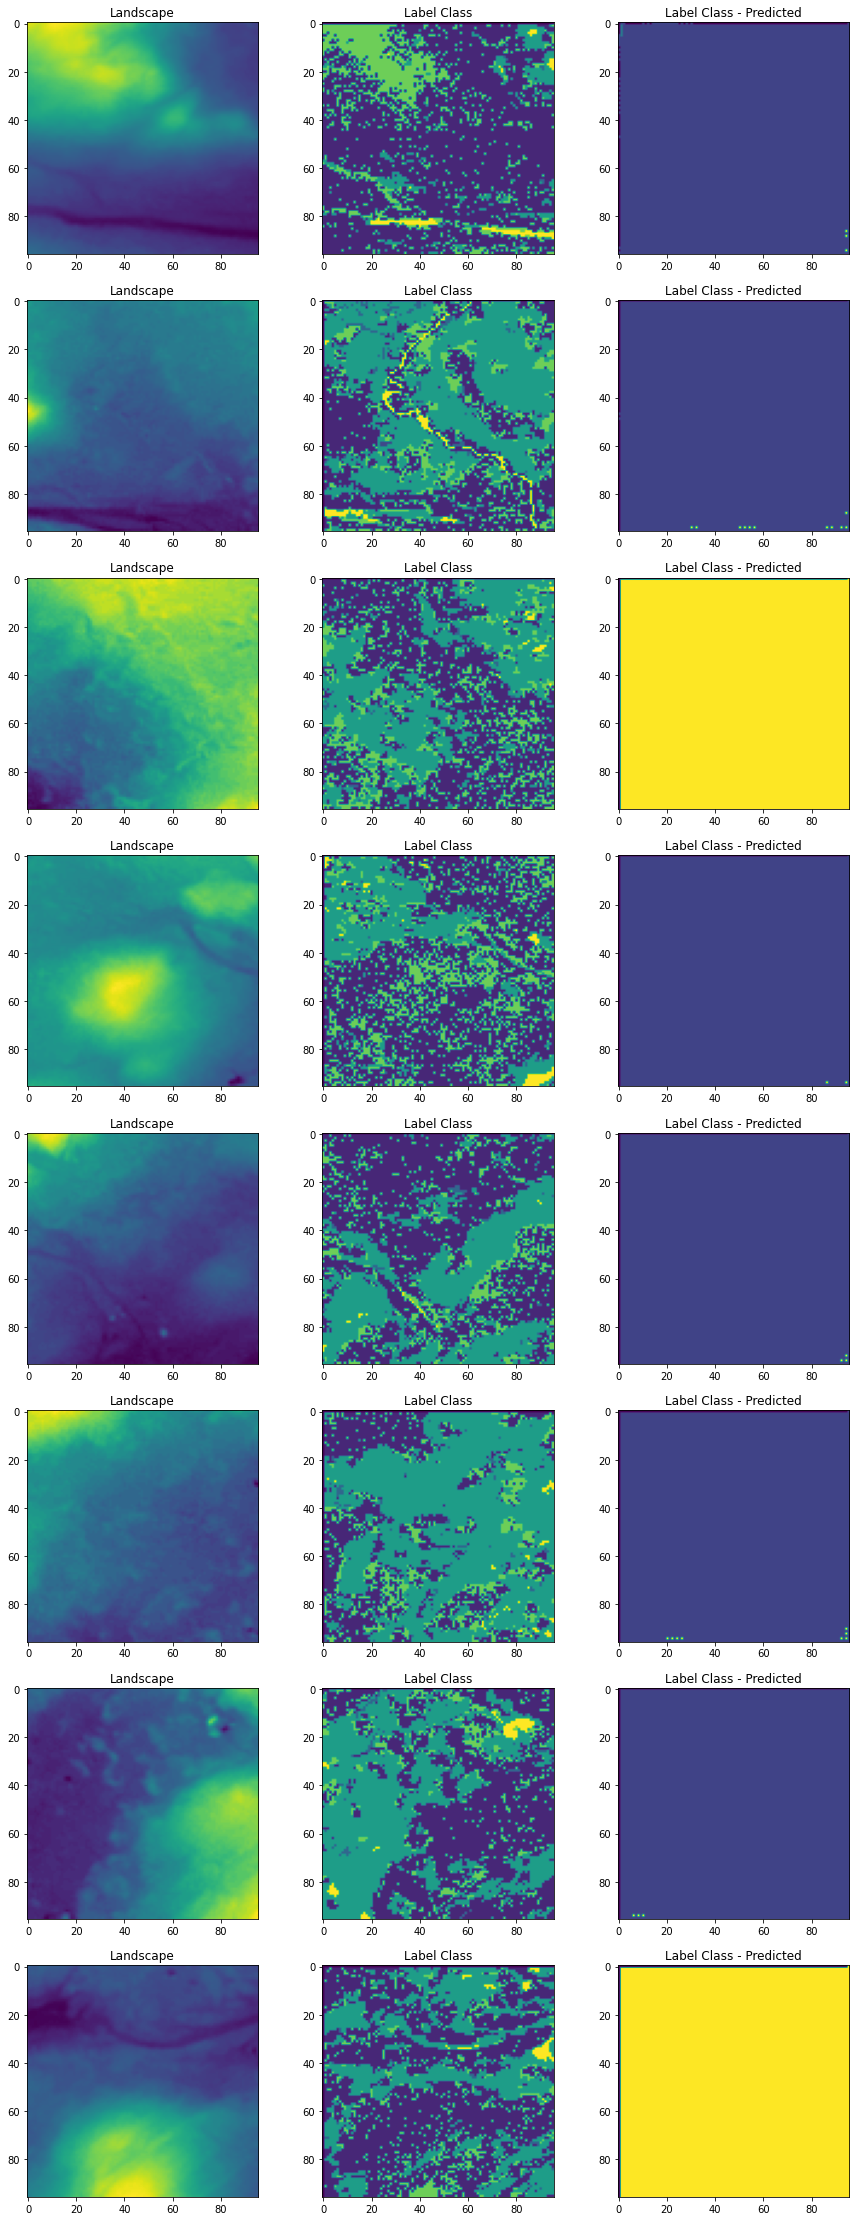

In [140]:
#global range normalization between 0 and 1
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    #landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

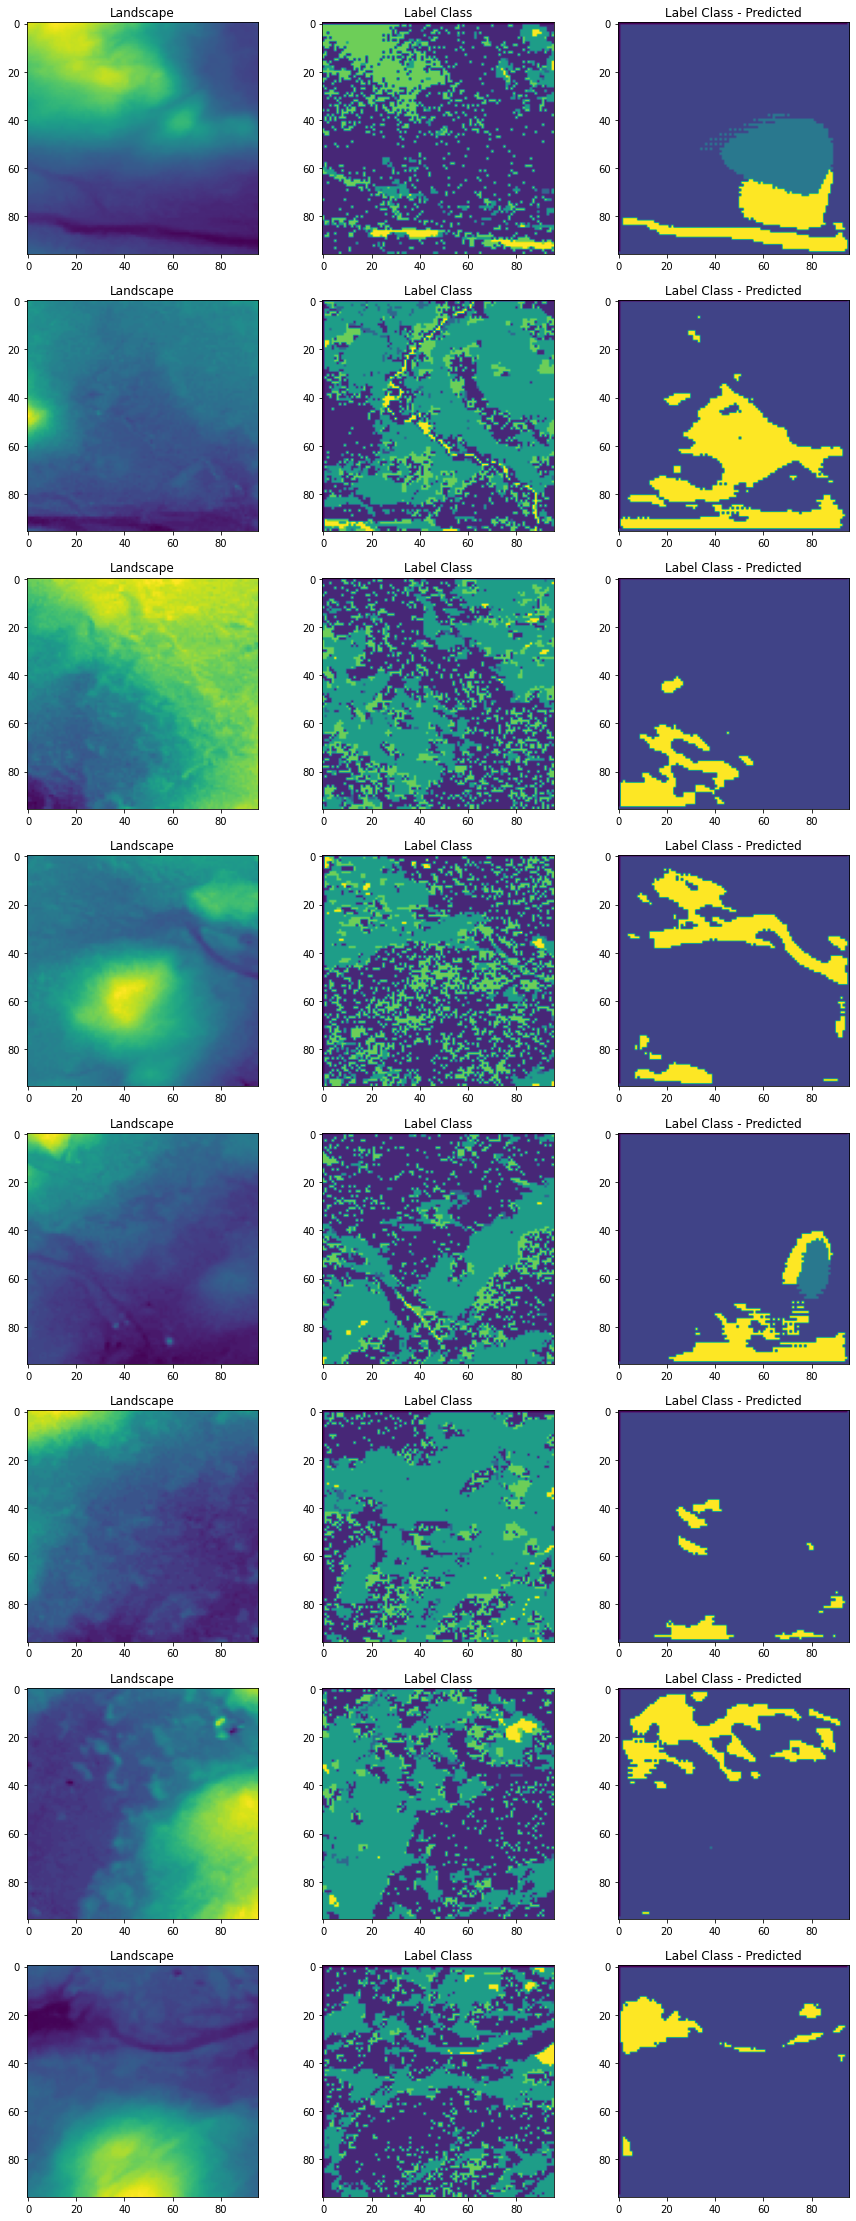

In [23]:
#local range normalization between 0 and 1
# mean and variance normalization
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    #landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")